In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

from util import ScoreDistribution, ROC_AUC, \
    prob_scale, get_resampling, PSI, xgbCV

In [2]:
df_treino = pd.read_csv('dataset/cs-training.csv')
df_treino.drop(columns='Unnamed: 0', inplace=True)
df_treino.rename(columns={'SeriousDlqin2yrs':'target'}, inplace=True)
df_treino.target = df_treino.target.apply(lambda target: 1 if target==0 else 0)
print(df_treino.dtypes)

target                                    int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


In [3]:
df_treino

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,1,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,1,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,1,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,1,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


<AxesSubplot:>

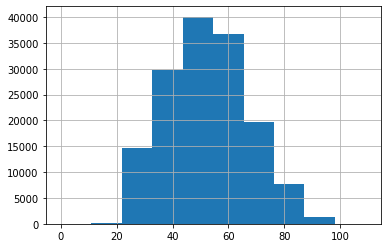

In [4]:
df_treino['age'].hist()

In [5]:
df_treino['target'].value_counts()

1    139974
0     10026
Name: target, dtype: int64

In [6]:
df_treino['target'].value_counts(normalize=True)

1    0.93316
0    0.06684
Name: target, dtype: float64

# Preparação de dados

In [7]:
df_treino['MonthlyIncome'] = np.log(1+df_treino['MonthlyIncome'].values)
df_treino['NumberOfDependents'] = np.log(1+df_treino['NumberOfDependents'].values)

df_treino['MonthlyIncome_Null'] = pd.isnull(df_treino['MonthlyIncome'])
df_treino['NoD_Null'] = pd.isnull(df_treino['NumberOfDependents'])

df_treino.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
df_treino.reset_index()

df_treino['IncomePerPerson'] = df_treino['MonthlyIncome']/\
    (df_treino['NumberOfDependents']+1)
df_treino['NumOfPastDue'] = \
    df_treino['NumberOfTimes90DaysLate']+\
    df_treino['NumberOfTime60-89DaysPastDueNotWorse']+\
    df_treino['NumberOfTime30-59DaysPastDueNotWorse']
df_treino['MonthlyDebt'] = df_treino['DebtRatio']*df_treino['MonthlyIncome']
df_treino['NumOfOpenCreditLines'] = df_treino['NumberOfOpenCreditLinesAndLoans']-\
    df_treino['NumberRealEstateLoansOrLines']
df_treino['MonthlyBalance'] = df_treino['MonthlyIncome']-df_treino['MonthlyDebt']

# Continua...

## remove outlier
df_treino = df_treino[df_treino['age'] != 0]
df_treino = df_treino[df_treino['age'] !=99]
df_treino = df_treino[df_treino['age'] !=101]

## create new features
df_treino['age_sqr'] = df_treino['age'].values^2 
## apply the same operation on testing set
df_treino['age_sqr'] = df_treino['age'].values^2

df_treino.drop(['MonthlyIncome_Null','NoD_Null'],axis=1,inplace=True)

In [8]:
df_treino.shape

(146067, 17)

In [9]:
df_treino.dtypes

target                                    int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
IncomePerPerson                         float64
NumOfPastDue                              int64
MonthlyDebt                             float64
NumOfOpenCreditLines                      int64
MonthlyBalance                          float64
age_sqr                                   int64
dtype: object

# Modelagem

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_treino.drop(columns='target'), 
                     df_treino['target'], 
                     test_size=0.33, random_state=42)

In [11]:
y_train.value_counts(normalize=True)

1    0.932784
0    0.067216
Name: target, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

1    0.932224
0    0.067776
Name: target, dtype: float64

In [13]:
X_train.shape

(97864, 16)

In [14]:
X_test.shape

(48203, 16)

In [15]:
train = xgb.DMatrix(X_train,y_train,feature_names=X_train.columns)
test = xgb.DMatrix(X_test,feature_names=X_test.columns)
xgb_params = {
    'eta':0.03,
    'max_depth':4,
    'sub_sample':0.9,
    'colsample_bytree':0.5,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'silent':0}

final_model = xgb.train(xgb_params,train,num_boost_round=500)

[21:36:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




# Avaliação

In [16]:
y_pred_train = final_model.predict(train)
y_pred_train

array([0.3626685 , 0.97099924, 0.9901703 , ..., 0.4203294 , 0.98742676,
       0.99301845], dtype=float32)

c:\Users\frank\businessds\util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


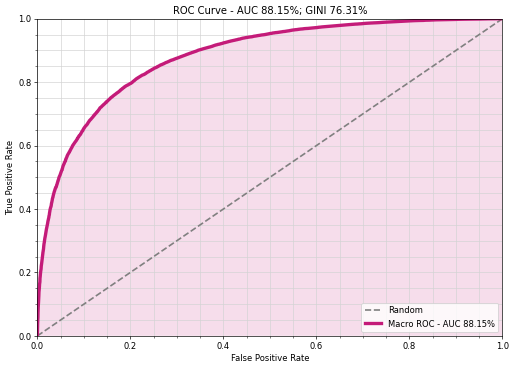

In [17]:
roc_auc_train = ROC_AUC(y_pred_train, y_train)
roc_auc_train.plot()

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


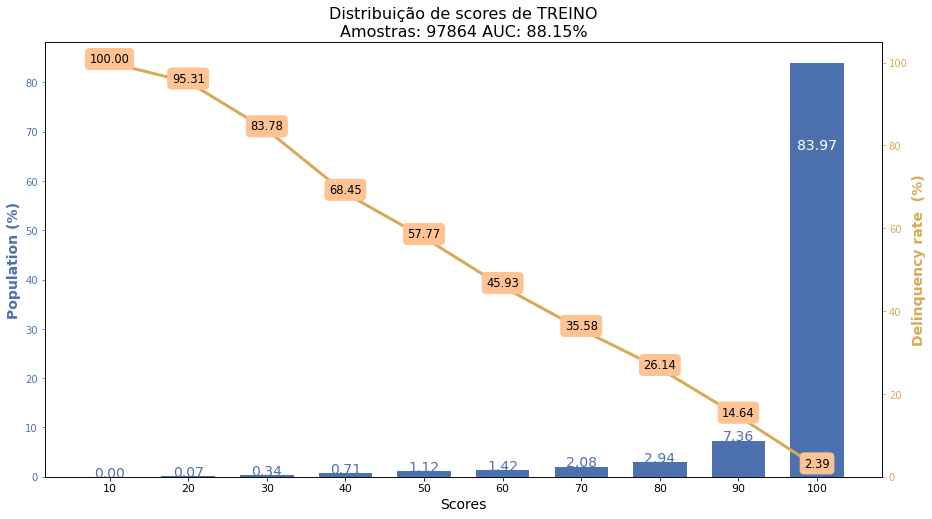

In [18]:
title_train = 'Distribuição de scores de TREINO\nAmostras: %d AUC: %.2f%%'%\
    (len(y_train), roc_auc_train.value*100)
ScoreDistribution(y_pred_train, y_train).plot(title=title_train)

In [19]:
y_pred = final_model.predict(test)
y_pred

array([0.99635077, 0.9735735 , 0.923949  , ..., 0.99042726, 0.8997998 ,
       0.93470746], dtype=float32)

c:\Users\frank\businessds\util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


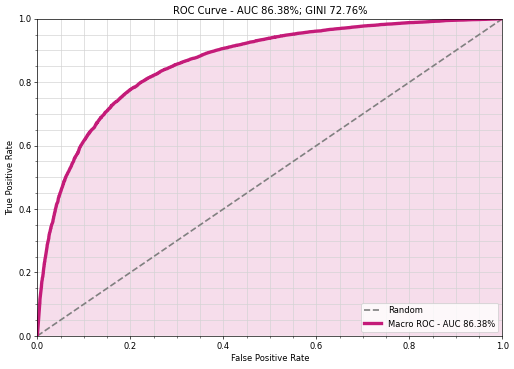

In [20]:
roc_auc_test = ROC_AUC(y_pred, y_test)
roc_auc_test.plot()

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


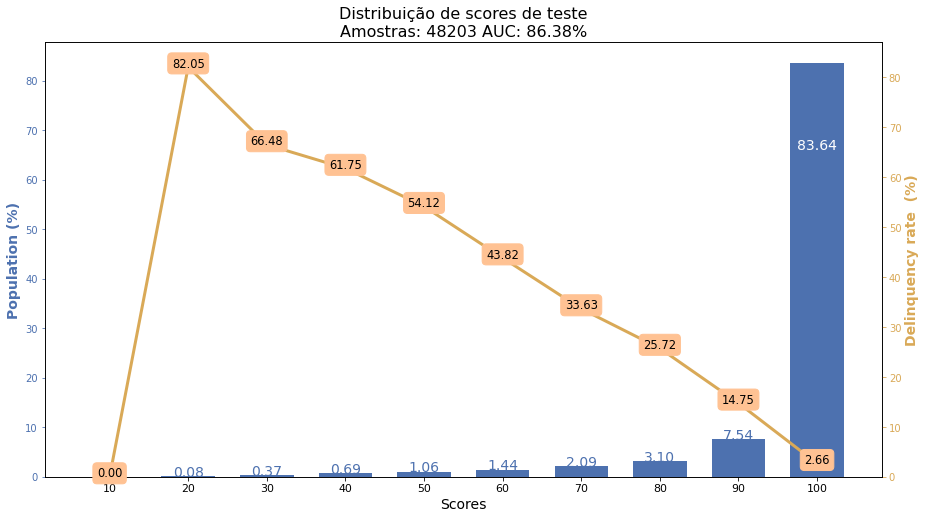

In [21]:
title_test = 'Distribuição de scores de teste\nAmostras: %d AUC: %.2f%%'%\
    (len(y_test), roc_auc_test.value*100)
ScoreDistribution(y_pred, y_test).plot(title=title_test)

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


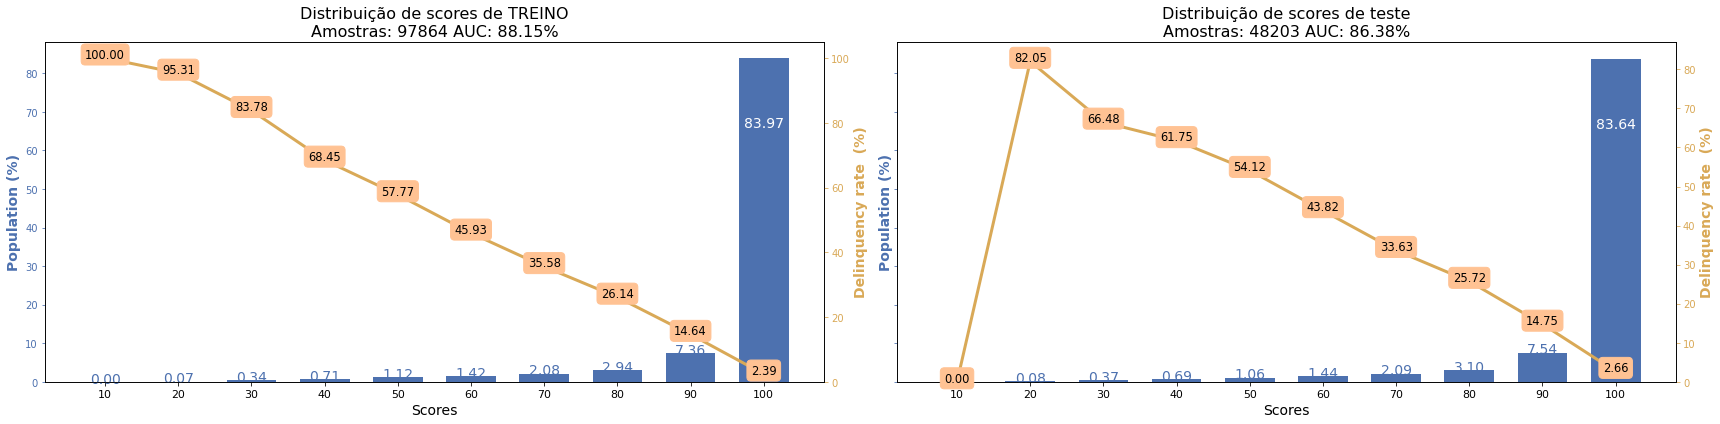

In [22]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
plt.tight_layout()
plt.show()

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:429: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels([


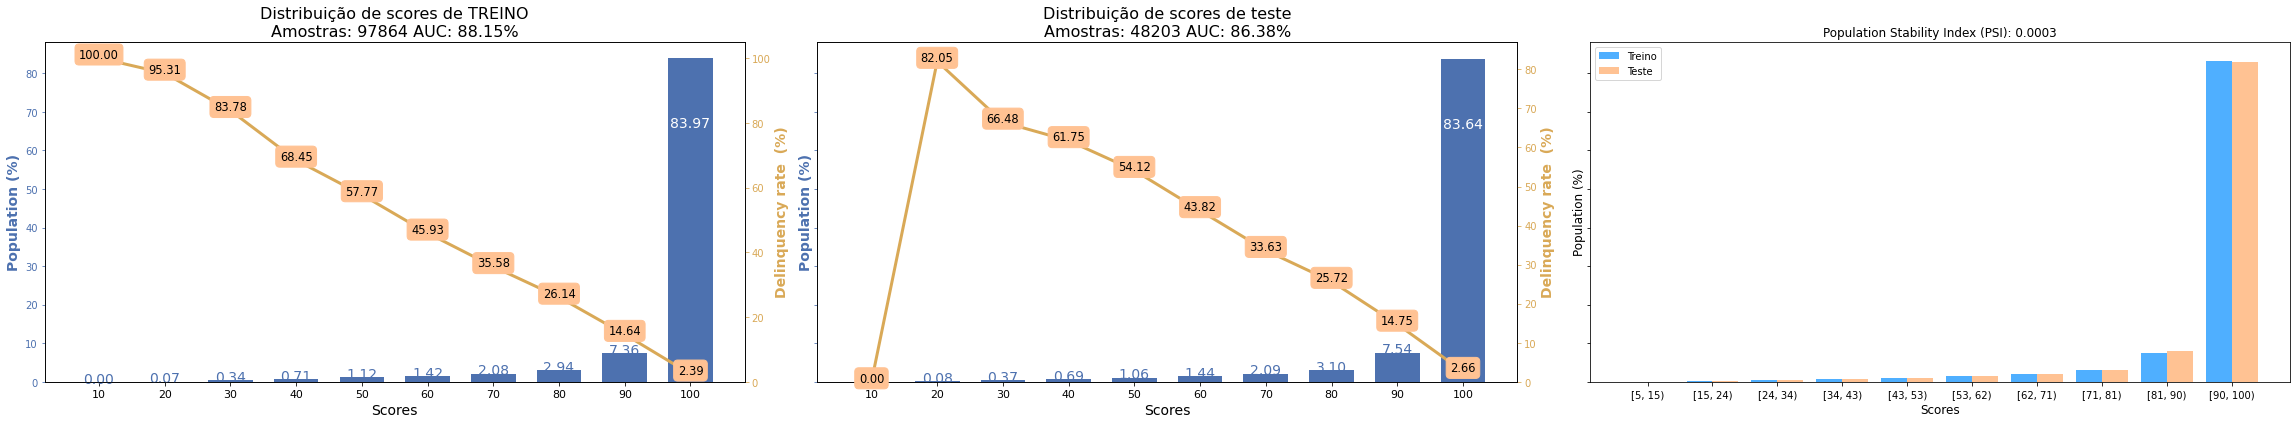

In [23]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
PSI(y_pred_train, y_pred).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

# Balanceamento de dados
- Dados: Oversampling (Randomica, SMOTE, ADASYN), Undersampling
- Código: Matriz de custo, Auto balanceamento

In [24]:
X_train_under, y_train_under = get_resampling(X_train, y_train, 
                                              verbose=False, 
                                              random_state=42, 
                                              by='undersampling', 
                                              good_mult=1)

In [25]:
y_train_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: bom_pagador, dtype: float64

In [26]:
train = xgb.DMatrix(X_train_under,y_train_under,
                    feature_names=X_train_under.columns)
test = xgb.DMatrix(X_test,feature_names=X_train_under.columns)
xgb_params = {
                    'eta':0.03,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model_under = xgb.train(xgb_params,train,num_boost_round=500)

[21:37:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




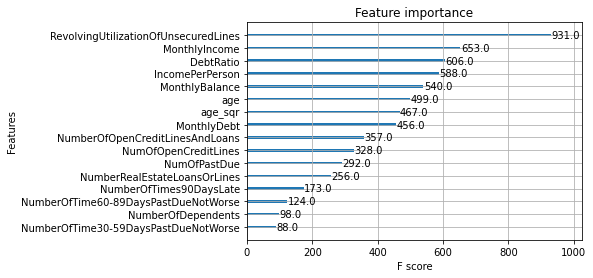

In [27]:
y_pred_train_under = final_model_under.predict(train)

xgb.plot_importance(final_model_under)
plt.show()

c:\Users\frank\businessds\util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


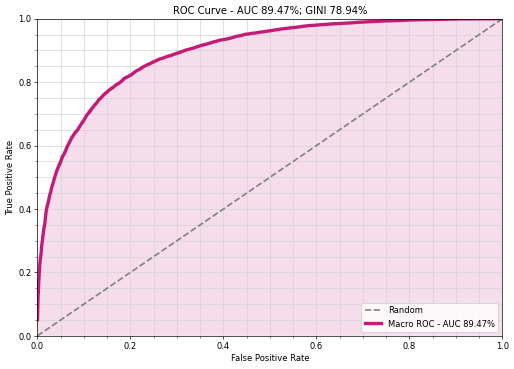

In [28]:
roc_auc_train_under = ROC_AUC(y_pred_train_under, y_train_under)
roc_auc_train_under.plot()

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


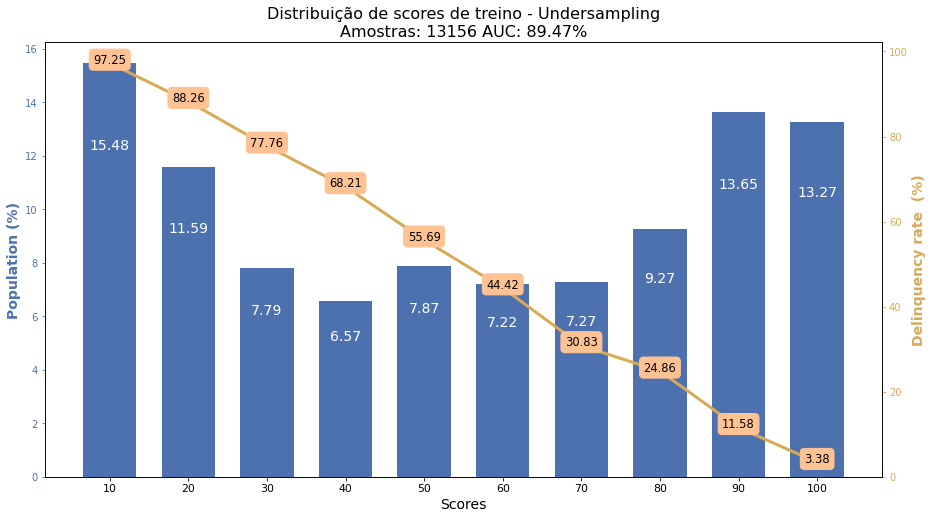

In [29]:
title_train_under = 'Distribuição de scores de treino - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_train_under), roc_auc_train_under.value*100)
ScoreDistribution(y_pred_train_under, y_train_under).plot(title=title_train_under)

# Métricas de teste - undersampling

c:\Users\frank\businessds\util.py:692: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random')


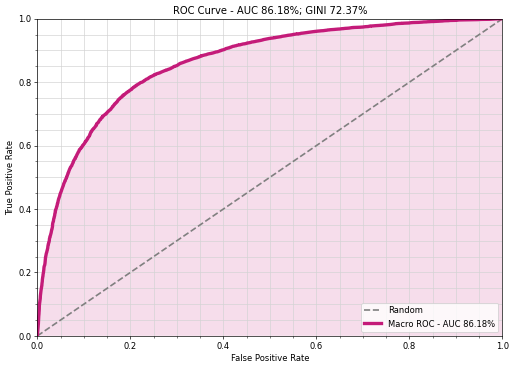

In [30]:
y_pred_under = final_model_under.predict(test)

roc_auc_test_under = ROC_AUC(y_pred_under, y_test)
roc_auc_test_under.plot()

In [31]:
X_test.head(2)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,NumOfPastDue,MonthlyDebt,NumOfOpenCreditLines,MonthlyBalance,age_sqr
44144,0.064525,71,0,1591.000000,NaN,6,0,1,0,0.0,NaN,0,NaN,5,NaN,69
8267,0.170445,34,0,0.525246,8.699681,9,0,2,0,0.0,8.699681,0,4.569471,7,4.13021,32


In [32]:
X_test.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'IncomePerPerson', 'NumOfPastDue', 'MonthlyDebt',
       'NumOfOpenCreditLines', 'MonthlyBalance', 'age_sqr'],
      dtype='object')

In [33]:
len(X_test.columns)

16

In [34]:
y_pred_under[:2]

array([0.9659582 , 0.70636225], dtype=float32)

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


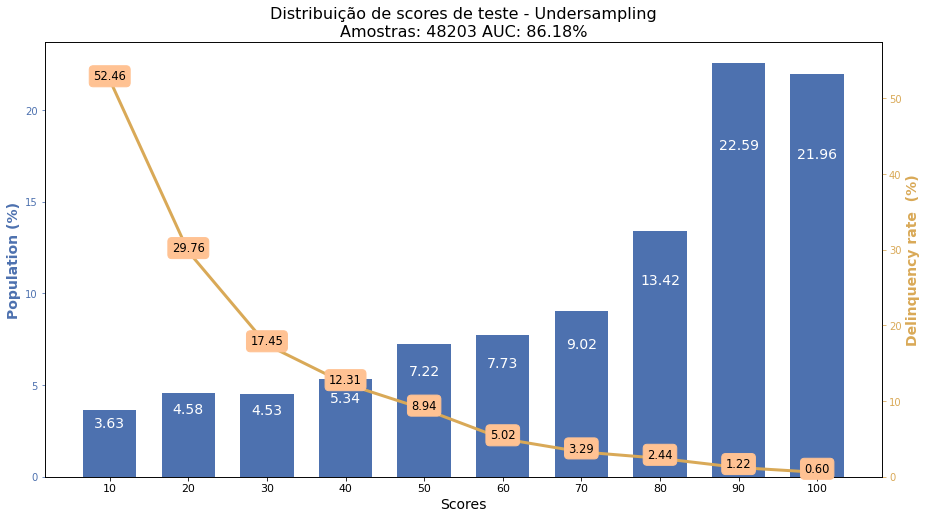

In [35]:
title_test_under = 'Distribuição de scores de teste - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_pred_under), roc_auc_test_under.value*100)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under)

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:429: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels([


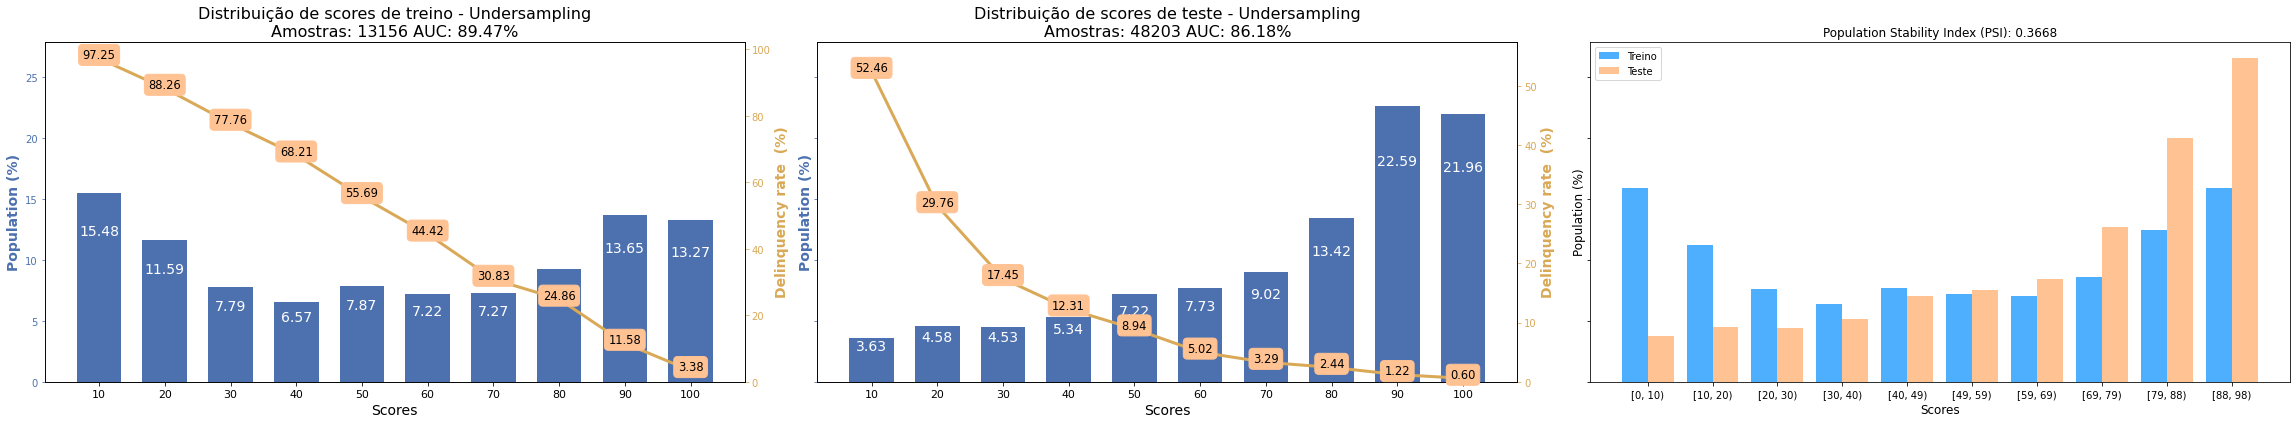

In [36]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train_under, y_train_under).plot(ax=axis[0],title=title_train_under)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
PSI(y_pred_train_under, y_pred_under).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

# Comparação de modelos

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


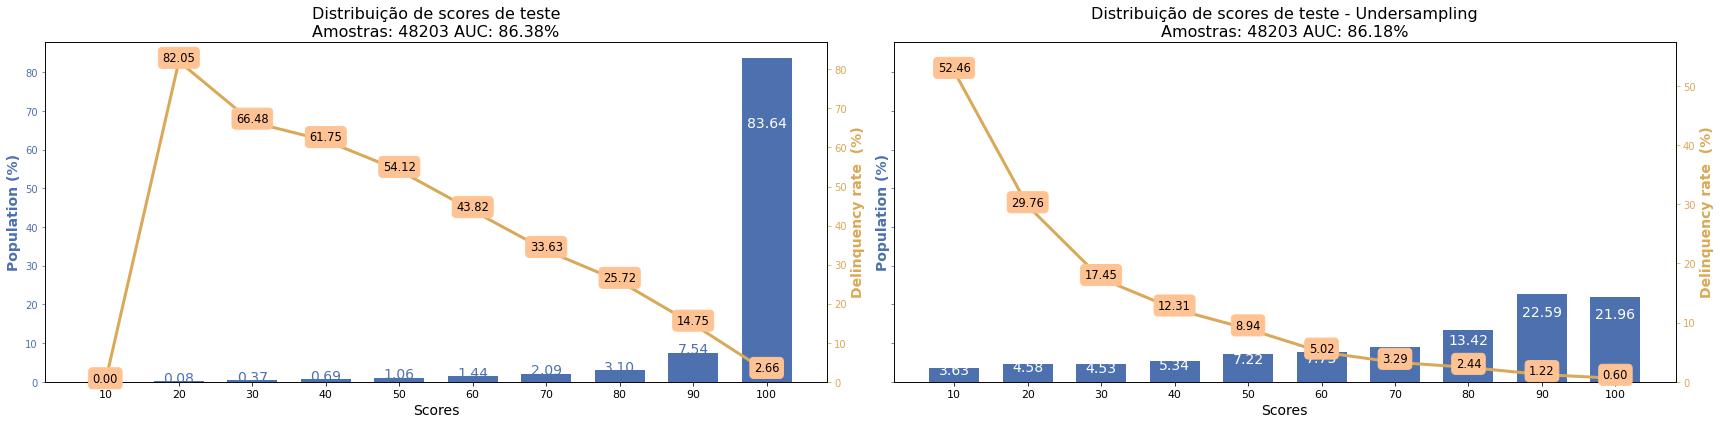

In [37]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(
c:\Users\frank\businessds\util.py:1054: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels(


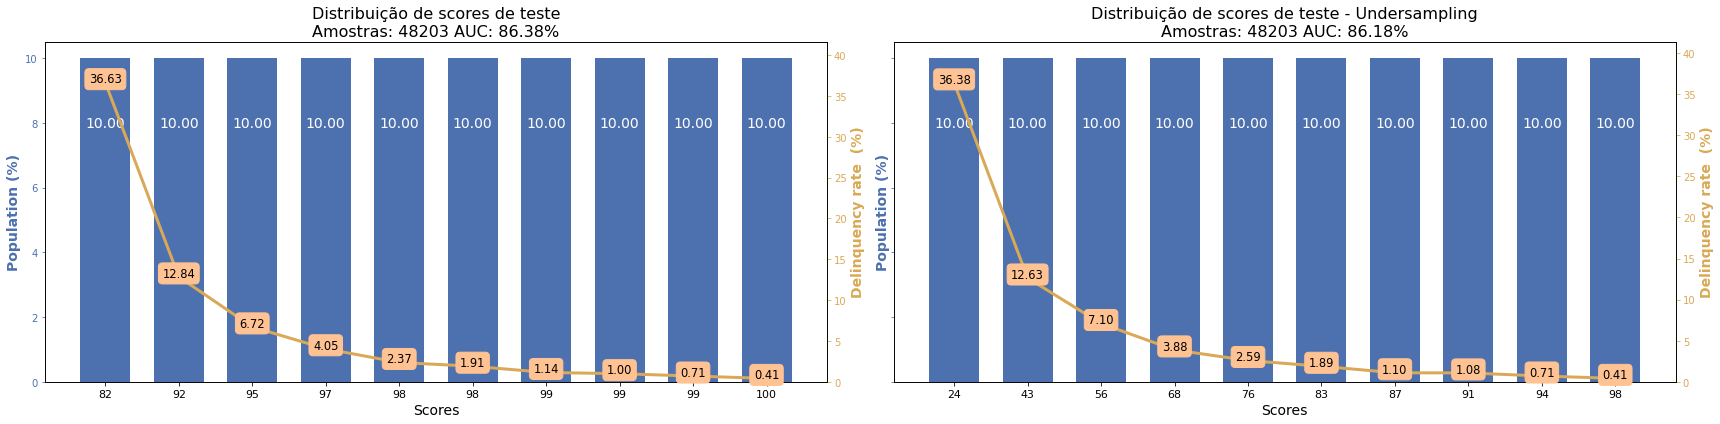

In [38]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test, buckets_as_quantiles=True).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test, buckets_as_quantiles=True).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

In [39]:
file_name = 'xgboost_undersampling.pkl'
pickle.dump(final_model_under, open(file_name, "wb"))